近月邏輯不用還原除權息方法，因為這樣以前價格會變低(假設股市長期趨勢是多頭)，導致可能無法觸發交易訊號

原版

In [2]:
# =============================================================================
#
#  唐奇安多指標整合策略 v16.0：簡化版（使用 bt_report_utils）
#
# =============================================================================
import backtrader as bt
import pandas as pd
import numpy as np
import sqlalchemy as sa
import urllib
from datetime import datetime, timedelta
import optuna
import quantstats as qs
import warnings

# 從自訂模組導入工具類別和函數
from bt_report_utils import (
    TaiFexCommInfo,           # 台指期貨手續費設定
    PnlListAnalyzer,          # 交易淨利分析器
    BaseLoggingStrategy,      # 包含日誌功能的基礎策略
    show_backtrader_report    # 完整報表生成函數
)

warnings.filterwarnings('ignore')

# =============================================================================
# 資料讀取與處理
# =============================================================================

def get_futures_data(start_date, end_date):
    """從資料庫讀取期貨資料"""
    try:
        server_name = "(localdb)\\MSSQLLocalDB"
        database_name = "quant"
        driver = "ODBC Driver 17 for SQL Server"
        params = urllib.parse.quote_plus(
            f"DRIVER={{{driver}}};SERVER={server_name};DATABASE={database_name};Trusted_Connection=yes;"
        )
        engine = sa.create_engine(f"mssql+pyodbc:///?odbc_connect={params}")
        
        sql_query = """
        SELECT [交易日期] AS [date], [開盤價] AS [open], [最高價] AS [high],
               [最低價] AS [low], [收盤價] AS [close], [成交量] AS [volume],
               [到期月份(週別)] AS [expiry]
        FROM dbo.期貨價格
        WHERE 契約 = 'MTX' AND [交易日期] BETWEEN ? AND ?
        ORDER BY [交易日期] ASC, [成交量] DESC;
        """
        df = pd.read_sql_query(sql_query, engine, params=(start_date, end_date))
    except Exception as e:
        print(f"讀取資料庫時發生錯誤: {e}")
        return None
    
    df['datetime'] = pd.to_datetime(df['date'])
    df.set_index('datetime', inplace=True)
    df.drop('date', axis=1, inplace=True)
    df.dropna(inplace=True)
    return df


def get_third_wednesday(year, month):
    """計算指定年月的第三個星期三（小指結算日）"""
    first_day = datetime(year, month, 1)
    days_ahead = 2 - first_day.weekday()  # 星期三是2
    if days_ahead < 0:
        days_ahead += 7
    first_wednesday = first_day + timedelta(days=days_ahead)
    third_wednesday = first_wednesday + timedelta(weeks=2)
    return third_wednesday.date()


def is_trading_day(date, trading_days_set):
    """檢查是否為交易日"""
    date_obj = date.date() if hasattr(date, 'date') else date
    return date_obj in trading_days_set


def get_next_trading_day(date, trading_days_list):
    """找到指定日期後的下一個交易日"""
    date_obj = date.date() if hasattr(date, 'date') else date
    for trading_day in trading_days_list:
        if trading_day > date_obj:
            return trading_day
    return None


def get_settlement_dates(start_date, end_date, raw_df):
    """獲取指定期間內所有的實際結算日期（考慮假日調整）"""
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    trading_days = sorted(list(set(raw_df.index.date)))
    trading_days_set = set(trading_days)
    settlement_dates = []
    
    current_date = start_dt
    while current_date <= end_dt:
        theoretical_settlement = get_third_wednesday(current_date.year, current_date.month)
        if start_dt.date() <= theoretical_settlement <= end_dt.date():
            if is_trading_day(theoretical_settlement, trading_days_set):
                actual_settlement = theoretical_settlement
            else:
                actual_settlement = get_next_trading_day(theoretical_settlement, trading_days)
                if not actual_settlement:
                    actual_settlement = theoretical_settlement
            settlement_dates.append(actual_settlement)
        current_date = current_date + pd.DateOffset(months=1)
    
    return sorted(settlement_dates)


def get_contract_month(date, settlement_dates):
    """根據日期和結算日判斷應該使用哪個月份的合約"""
    date_obj = date.date() if hasattr(date, 'date') else date
    for settlement_date in settlement_dates:
        if date_obj <= settlement_date:
            return f"{settlement_date.year}{settlement_date.month:02d}"
    
    if settlement_dates:
        last_settlement = settlement_dates[-1]
        if last_settlement.month == 12:
            return f"{last_settlement.year + 1}01"
        else:
            return f"{last_settlement.year}{last_settlement.month + 1:02d}"
    return None


def create_continuous_contract(raw_df):
    """基於結算日邏輯建立連續合約（不調整價格）"""
    print("正在使用結算日邏輯生成【非調整】連續合約...")
    raw_df['expiry'] = raw_df['expiry'].astype(str)
    date_range = [raw_df.index.min().date(), raw_df.index.max().date()]
    settlement_dates = get_settlement_dates(date_range[0], date_range[1], raw_df)
    
    continuous_data = []
    current_contract = None
    all_trading_days = sorted(list(set(raw_df.index)))
    
    for date in all_trading_days:
        date_data = raw_df[raw_df.index.date == date.date()]
        if date_data.empty:
            continue
        
        target_contract = get_contract_month(date.date(), settlement_dates)
        if target_contract is None:
            continue
        
        if target_contract != current_contract:
            current_contract = target_contract
        
        target_data = date_data[date_data['expiry'].str.contains(target_contract[:6], na=False)]
        if target_data.empty:
            target_data = date_data.loc[[date_data['volume'].idxmax()]]
        
        if len(target_data) > 1:
            target_data = target_data.loc[[target_data['volume'].idxmax()]]
        
        continuous_data.append({
            'date': date,
            'open': target_data['open'].iloc[0],
            'high': target_data['high'].iloc[0],
            'low': target_data['low'].iloc[0],
            'close': target_data['close'].iloc[0],
            'volume': target_data['volume'].iloc[0]
        })
    
    continuous_df = pd.DataFrame(continuous_data)
    continuous_df.set_index('date', inplace=True)
    continuous_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    continuous_df.dropna(inplace=True)
    
    # 確保 high/low 的合理性
    continuous_df['high'] = continuous_df[['open', 'high', 'low', 'close']].max(axis=1)
    continuous_df['low'] = continuous_df[['open', 'high', 'low', 'close']].min(axis=1)
    
    result_df = continuous_df[['open', 'high', 'low', 'close', 'volume']]
    print(f"\n連續合約建立完成, 日期範圍: {result_df.index.min().date()} 到 {result_df.index.max().date()}")
    return result_df

# =============================================================================
# 策略定義（繼承 BaseLoggingStrategy 以獲得日誌功能）
# =============================================================================

class IntegratedStrategy(BaseLoggingStrategy):
    """
    多指標整合策略：結合唐奇安通道、RSI、布林通道
    繼承 BaseLoggingStrategy 以自動獲得交易日誌功能
    """
    params = dict(
        lookback_period=20,    # 唐奇安通道週期
        rsi_period=14,         # RSI 週期
        bollinger_period=20,   # 布林通道週期
        std_dev=2.0,           # 布林通道標準差倍數
        printlog=False         # 是否顯示日誌
    )
    
    def __init__(self):
        # 呼叫父類初始化（獲得 self.order 等屬性）
        super().__init__()
        
        # 唐奇安通道指標
        self.donchian_high = bt.indicators.Highest(
            self.data.high, 
            period=self.p.lookback_period
        )
        self.donchian_low = bt.indicators.Lowest(
            self.data.low, 
            period=self.p.lookback_period
        )
        
        # RSI 指標
        self.rsi = bt.indicators.RSI(period=self.p.rsi_period)
        
        # 布林通道指標
        self.bband = bt.indicators.BollingerBands(
            period=self.p.bollinger_period, 
            devfactor=self.p.std_dev
        )
    
    def next(self):
        # 如果已有持倉，檢查出場條件
        if self.position:
            if self.position.size > 0 and self.donchian_high[0] <= self.donchian_high[-1]:
                self.close()
            elif self.position.size < 0 and self.donchian_low[0] >= self.donchian_low[-1]:
                self.close()
            return
        
        # 多頭進場條件
        is_donchian_rising = self.donchian_high[0] > self.donchian_high[-1]
        is_rsi_not_overbought = self.rsi[0] < 70
        is_not_bb_extreme = self.data.close[0] < self.bband.lines.top[0]
        
        if is_donchian_rising and is_rsi_not_overbought and is_not_bb_extreme:
            self.buy()
        
        # 空頭進場條件
        is_donchian_falling = self.donchian_low[0] < self.donchian_low[-1]
        is_rsi_not_oversold = self.rsi[0] > 30
        is_not_bb_extreme_short = self.data.close[0] > self.bband.lines.bot[0]
        
        if is_donchian_falling and is_rsi_not_oversold and is_not_bb_extreme_short:
            self.sell()

# =============================================================================
# 輔助函數：添加標準分析器
# =============================================================================

def add_standard_analyzers(cerebro):
    """
    為 Cerebro 添加標準分析器組合
    這些分析器是 show_backtrader_report() 所需要的
    """
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe_ratio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')
    cerebro.addanalyzer(PnlListAnalyzer, _name='pnllistanalyzer')
    return cerebro

# =============================================================================
# Optuna 優化目標函數
# =============================================================================

def objective(trial, data, initial_cash, slippage_ticks, tick_size):
    """Optuna 優化目標函數：最大化 Sharpe Ratio"""
    params = {
        'lookback_period': trial.suggest_int('lookback_period', 20, 60, step=5),
        'rsi_period': trial.suggest_int('rsi_period', 10, 30, step=2),
        'bollinger_period': trial.suggest_int('bollinger_period', 15, 30, step=5),
        'std_dev': trial.suggest_float('std_dev', 1.5, 3.0, step=0.25)
    }
    
    try:
        cerebro = bt.Cerebro(stdstats=False)
        cerebro.adddata(bt.feeds.PandasData(dataname=data))
        cerebro.addstrategy(IntegratedStrategy, **params)
        
        # 設定初始資金和手續費
        cerebro.broker.setcash(initial_cash)
        cerebro.broker.addcommissioninfo(TaiFexCommInfo())
        cerebro.broker.set_slippage_fixed(slippage_ticks * tick_size)
        
        # 只添加 Sharpe Ratio 分析器用於優化
        cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe_ratio')
        
        results = cerebro.run()
        sharpe = results[0].analyzers.sharpe_ratio.get_analysis().get('sharperatio', -2.0)
        return sharpe if sharpe is not None else -2.0
    
    except Exception:
        return -999.0

# =============================================================================
# 主執行程式
# =============================================================================

if __name__ == '__main__':
    # 回測參數設定
    START_DATE = '2018-01-01'
    END_DATE = '2025-09-20'
    INITIAL_CASH = 330000
    SLIPPAGE_TICKS = 1
    TICK_SIZE = 1.0
    OPTUNA_TRIALS = 100
    
    # 1. 讀取資料
    print("=" * 70)
    print("步驟 1: 讀取期貨資料")
    print("=" * 70)
    raw_dataframe = get_futures_data(start_date=START_DATE, end_date=END_DATE)
    
    if raw_dataframe is None or raw_dataframe.empty:
        print("❌ 無法讀取資料，程式結束")
        exit(1)
    
    # 2. 建立連續合約
    print("\n" + "=" * 70)
    print("步驟 2: 建立連續合約")
    print("=" * 70)
    dataframe = create_continuous_contract(raw_dataframe)
    
    # 3. Optuna 參數優化
    print("\n" + "=" * 70)
    print(f"步驟 3: 開始參數優化 (共 {OPTUNA_TRIALS} 次試驗)")
    print("=" * 70)
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42)  # 設定隨機種子確保可重現性
    )
    study.optimize(
        lambda trial: objective(trial, dataframe, INITIAL_CASH, SLIPPAGE_TICKS, TICK_SIZE),
        n_trials=OPTUNA_TRIALS,
        show_progress_bar=True
    )
    
    best_trial = study.best_trial
    print("\n--- Optuna 優化完成 ---")
    print(f"最佳 Sharpe Ratio: {best_trial.value:.4f}")
    print(f"最佳參數組合:")
    for key, value in best_trial.params.items():
        print(f"  {key}: {value}")
    
    # 4. 使用最佳參數執行最終回測
    print("\n" + "=" * 70)
    print("步驟 4: 執行最終回測")
    print("=" * 70)
    cerebro_final = bt.Cerebro()
    cerebro_final.adddata(bt.feeds.PandasData(dataname=dataframe))
    cerebro_final.addstrategy(IntegratedStrategy, printlog=True, **best_trial.params)
    
    # 設定初始資金和手續費
    cerebro_final.broker.setcash(INITIAL_CASH)
    cerebro_final.broker.addcommissioninfo(TaiFexCommInfo())
    cerebro_final.broker.set_slippage_fixed(SLIPPAGE_TICKS * TICK_SIZE)
    
    # 添加標準分析器組合
    add_standard_analyzers(cerebro_final)
    
    # 執行回測
    final_run_results = cerebro_final.run()
    
    # 5. 顯示完整報表（使用 bt_report_utils）
    print("\n" + "=" * 70)
    print("步驟 5: 績效報表")
    print("=" * 70)
    show_backtrader_report(
        final_run_results, 
        cerebro_final, 
        dataframe, 
        strategy_name="IntegratedStrategy"
    )
    
    # 6. 生成 QuantStats 報告
    print("\n" + "=" * 70)
    print("步驟 6: 生成 QuantStats 報告")
    print("=" * 70)
    returns = pd.Series(final_run_results[0].analyzers.timereturn.get_analysis())
    benchmark = dataframe['close'].pct_change().reindex(returns.index).fillna(0)
    
    qs.reports.html(
        returns,
        benchmark=benchmark,
        output='integrated_strategy_report.html',
        title='Integrated Strategy (Donchian + RSI + Bollinger)'
    )
    print("✅ QuantStats 報告已生成: integrated_strategy_report.html")
    
    # 7. 顯示 BackTrader 圖表
    print("\n" + "=" * 70)
    print("步驟 7: 顯示交易圖表")
    print("=" * 70)
    cerebro_final.plot(style='candlestick', barup='red', bardown='green')
    
    print("\n" + "=" * 70)
    print("🎉 所有步驟完成！")
    print("=" * 70)

c:\Users\DELL\miniforge3\envs\quant_arm64\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


步驟 1: 讀取期貨資料

步驟 2: 建立連續合約
正在使用結算日邏輯生成【非調整】連續合約...


[I 2025-11-08 21:47:20,747] A new study created in memory with name: no-name-ffc20073-c28d-40d3-8566-5d15f4c9c7db



連續合約建立完成, 日期範圍: 2018-01-02 到 2025-09-19

步驟 3: 開始參數優化 (共 100 次試驗)


Best trial: 0. Best value: -0.0975436:   1%|          | 1/100 [00:00<00:46,  2.15it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-05 買進執行 @ 11102.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2350.00, 淨利 2283.75
2018-06-27 賣出執行 @ 10585.00, 成本: 76500.00, 手續費: 32.59
2018-06-28 買進執行 @ 10516.00, 成本: 76500.00, 手續費: 32.52
2018-06-28 交易損益: 毛利 3450.00, 淨利 3384.90
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-09 買進執行 @ 11033.00, 成本: 76500.00, 手續費: 33.03
2018-08-10 賣出執行 @ 10969.00, 成本: 76500.00, 手續費: 32.97
2018-08-10 交易損益: 毛利 -3200.00, 淨利 -3266.00
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛

Best trial: 1. Best value: 0.000958913:   2%|▏         | 2/100 [00:00<00:47,  2.08it/s]

2025-09-09 買進執行 @ 24720.00, 成本: 76500.00, 手續費: 46.72
2025-09-15 賣出執行 @ 25404.00, 成本: 76500.00, 手續費: 47.40
2025-09-15 交易損益: 毛利 34200.00, 淨利 34105.88
[I 2025-11-08 21:47:21,711] Trial 1 finished with value: 0.000958912928109343 and parameters: {'lookback_period': 25, 'rsi_period': 12, 'bollinger_period': 15, 'std_dev': 3.0}. Best is trial 1 with value: 0.000958912928109343.
2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-05 買進執行 @ 11102.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2350.00, 淨利 2283.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-08 賣出執行 @ 10467.00, 成本: 76500.00,

Best trial: 1. Best value: 0.000958913:   3%|▎         | 3/100 [00:01<00:50,  1.94it/s]

2024-02-16 買進執行 @ 18667.00, 成本: 76500.00, 手續費: 40.67
2024-02-20 賣出執行 @ 18633.00, 成本: 76500.00, 手續費: 40.63
2024-02-20 交易損益: 毛利 -1700.00, 淨利 -1781.30
2024-02-29 買進執行 @ 18812.00, 成本: 76500.00, 手續費: 40.81
2024-03-01 賣出執行 @ 18968.00, 成本: 76500.00, 手續費: 40.97
2024-03-01 交易損益: 毛利 7800.00, 淨利 7718.22
2024-05-14 買進執行 @ 20883.00, 成本: 76500.00, 手續費: 42.88
2024-05-20 賣出執行 @ 21436.00, 成本: 76500.00, 手續費: 43.44
2024-05-20 交易損益: 毛利 27650.00, 淨利 27563.68
2024-05-23 買進執行 @ 21620.00, 成本: 76500.00, 手續費: 43.62
2024-05-30 賣出執行 @ 21507.00, 成本: 76500.00, 手續費: 43.51
2024-05-30 交易損益: 毛利 -5650.00, 淨利 -5737.13
2024-06-13 買進執行 @ 22311.00, 成本: 76500.00, 手續費: 44.31
2024-06-17 賣出執行 @ 22499.00, 成本: 76500.00, 手續費: 44.50
2024-06-17 交易損益: 毛利 9400.00, 淨利 9311.19
2024-06-18 買進執行 @ 22726.00, 成本: 76500.00, 手續費: 44.73
2024-06-25 賣出執行 @ 22593.00, 成本: 76500.00, 手續費: 44.59
2024-06-25 交易損益: 毛利 -6650.00, 淨利 -6739.32
2024-07-05 買進執行 @ 23649.00, 成本: 76500.00, 手續費: 45.65
2024-07-11 賣出執行 @ 24262.00, 成本: 76500.00, 手續費: 46.26
2024-07-11

Best trial: 3. Best value: 0.455064:   4%|▍         | 4/100 [00:01<00:46,  2.08it/s]   

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛利 2100.00, 淨利 2035.08
2019-04-02 買進執行 @ 10688.00, 成本: 76500.00, 手續費: 32.69
2019-04-03 賣出執行 @ 10684.00, 成本: 76500.00, 手續費: 32.68
2019-04-03 交易損益: 毛利 -200.00, 淨利 -265.37
2019-04-08 買進執行 @ 10779.00, 成本: 76500.00, 手續費: 32.78
2019-04-15 賣出執行 @ 10861.00, 成本: 76500.00, 手續費: 32.86
2019-04-15 交易損益: 毛利 4100.00, 淨利 4034.36
2019-07-04 賣出執行 @ 10691.00, 成本: 76500.00, 手續費: 32.69
2019-07-05 買進執行 @ 10713.00, 成本: 76500.00, 手續費: 32.71
2019-07-05 交易損益:

Best trial: 3. Best value: 0.455064:   5%|▌         | 5/100 [00:02<00:44,  2.12it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-06-27 賣出執行 @ 10585.00, 成本: 76500.00, 手續費: 32.59
2018-06-28 買進執行 @ 10516.00, 成本: 76500.00, 手續費: 32.52
2018-06-28 交易損益: 毛利 3450.00, 淨利 3384.90
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-02 買進執行 @ 11049.00, 成本: 76500.00, 手續費: 33.05
2018-08-03 賣出執行 @ 10934.00, 成本: 76500.00, 手續費: 32.93
2018-08-03 交易損益: 毛利 -5750.00, 淨利 -5815.98
2018-08-09 買進執行 @ 11033.00, 成本: 76500.00, 手續費: 33.03
2018-08-10 賣出執行 @ 10969.00, 成本: 76500.00, 手續費: 32.97
2018-08-10 交易損益: 毛利 -3200.00, 淨利 -3266.00
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損

Best trial: 3. Best value: 0.455064:   6%|▌         | 6/100 [00:02<00:43,  2.16it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛

Best trial: 3. Best value: 0.455064:   7%|▋         | 7/100 [00:03<00:43,  2.12it/s]

[I 2025-11-08 21:47:24,083] Trial 6 finished with value: 0.19781888322671334 and parameters: {'lookback_period': 40, 'rsi_period': 26, 'bollinger_period': 15, 'std_dev': 2.25}. Best is trial 3 with value: 0.4550644874177951.


Best trial: 7. Best value: 0.575342:   8%|▊         | 8/100 [00:03<00:41,  2.21it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛利 2100.00, 淨利 2035.08
2019-07-04 賣出執行 @ 10691.00, 成本: 76500.00, 手續費: 32.69
2019-07-05 買進執行 @ 10713.00, 成本: 76500.00, 手續費: 32.71
2019-07-05 交易損益: 毛利 -1100.00, 淨利 -1165.40
2019-09-18 買進執行 @ 10911.00, 成本: 76500.00, 手續費: 32.91
2019-09-20 賣出執行 @ 10900.00, 成本: 76500.00, 手續費: 32.90
2019-09-20 交易損益:

Best trial: 7. Best value: 0.575342:   9%|▉         | 9/100 [00:04<00:42,  2.13it/s]

[I 2025-11-08 21:47:25,000] Trial 8 finished with value: 0.18072662929215985 and parameters: {'lookback_period': 20, 'rsi_period': 30, 'bollinger_period': 30, 'std_dev': 2.75}. Best is trial 7 with value: 0.5753419709195697.


Best trial: 7. Best value: 0.575342:  10%|█         | 10/100 [00:04<00:41,  2.18it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-05 買進執行 @ 11102.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2350.00, 淨利 2283.75
2018-06-25 賣出執行 @ 10624.00, 成本: 76500.00, 手續費: 32.62
2018-06-26 買進執行 @ 10546.00, 成本: 76500.00, 手續費: 32.55
2018-06-26 交易損益: 毛利 3900.00, 淨利 3834.83
2018-06-27 賣出執行 @ 10585.00, 成本: 76500.00, 手續費: 32.59
2018-06-28 買進執行 @ 10516.00, 成本: 76500.00, 手續費: 32.52
2018-06-28 交易損益: 毛利 3450.00, 淨利 3384.90
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-02 買進執行 @ 11049.00, 成本: 76500.00, 手續費: 33.05
2018-08-03 賣出執行 @ 10934.00, 成本: 76500.00, 手續費: 32.93
2018-08-03 交易損益: 毛利 -5750.00, 淨利 -5815.98
2018-08-09 買進執行 @ 11033.00, 成本: 76500.00, 手續費: 33.03
2018-08-10 賣出執行 @ 10969.00, 成本: 76500.00, 手續費: 32.97
2018-08-10 交易損益:

Best trial: 7. Best value: 0.575342:  11%|█         | 11/100 [00:05<00:39,  2.26it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛利 2100.00, 淨利 2035.08
2019-07-04 賣出執行 @ 10691.00, 成本: 76500.00, 手續費: 32.69
2019-07-05 買進執行 @ 10713.00, 成本: 76500.00, 手續費: 32.71
2019-07-05 交易損益: 毛利 -1100.00, 淨利 -1165.40
2019-10-09 買進執行 @ 10965.00, 成本: 76500.00, 手續費: 32.97
2019-10-14 賣出執行 @ 11064.00, 成本: 76500.00, 手續費: 33.06
2019-10-14 交易損益: 毛利 4950.00, 淨利 4883.97
2019-12-10 買進執行 @ 11650.00, 成本: 76500.00, 手續費: 33.65
2019-12-11 賣出執行 @ 11602.00, 成本: 76500.00, 手續費: 33.60
2019-12-11 交易損益: 毛利 -2400.00, 淨利 -2467.25
2020-01-06 買進執行 @ 12023.00, 成本: 76500.00, 手續費: 34.02
2020-01-07 賣出執行 @ 11992.00, 成本: 76500.00, 手續費: 33.99
2020-01-07 交

Best trial: 7. Best value: 0.575342:  12%|█▏        | 12/100 [00:05<00:37,  2.32it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛利 2100.00, 淨利 2035.08
2019-07-04 賣出執行 @ 10691.00, 成本: 76500.00, 手續費: 32.69
2019-07-05 買進執行 @ 10713.00, 成本: 76500.00, 手續費: 32.71
2019-07-05 交易損益: 毛利 -1100.00, 淨利 -1165.40
2020-01-06 買進執行 @ 12023.00, 成本: 76500.00, 手續費: 34.02
2020-01-07 賣出執行 @ 11992.00, 成本: 76500.00, 手續費: 33.99
2020-01-07 交易損益: 毛利 -1550.00, 淨利 -1618.02
2020-06-12 買進執行 @ 11335.00, 成本: 76500.00, 手續費: 33.34
2020-06-15 賣出執行 @ 11357.00, 成本: 76500.00, 手續費: 33.36
2020-06-15 交易損益: 毛利 1100.00, 淨利 1033.31
2020-07-22 買進執行 @ 12304.00, 成本: 76500.00, 手續費: 34.30
2020-07-24 賣出執行 @ 12223.00, 成本: 76500.00, 手續費: 34.22
2020-07-24 交

Best trial: 7. Best value: 0.575342:  13%|█▎        | 13/100 [00:05<00:36,  2.36it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛利 2100.00, 淨利 2035.08
2019-04-02 買進執行 @ 10688.00, 成本: 76500.00, 手續費: 32.69
2019-04-03 賣出執行 @ 10684.00, 成本: 76500.00, 手續費: 32.68
2019-04-03 交易損益: 毛利 -200.00, 淨利 -265.37
2019-07-04 賣出執行 @ 10691.00, 成本: 76500.00, 手續費: 32.69
2019-07-05 買進執行 @ 10713.00, 成本: 76500.00, 手續費: 32.71
2019-07-05 交易損益: 毛利 -1100.00, 淨利 -1165.40
2019-09-18 買進執行 @ 10911.00, 成本: 76500.00, 手續費: 32.91
2019-09-20 賣出執行 @ 10900.00, 成本: 76500.00, 手續費: 32.90
2019-09-20 交易損益: 毛利 -550.00, 淨利 -615.81
2019-10-24 買進執行 @ 11234.00, 成本: 76500.00, 手續費: 33.23
2019-10-31 賣出執行 @ 11368.00, 成本: 76500.00, 手續費: 33.37
2019-10-31 交易損

Best trial: 7. Best value: 0.575342:  14%|█▍        | 14/100 [00:06<00:36,  2.36it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛利 2100.00, 淨利 2035.08
2019-04-12 買進執行 @ 10817.00, 成本: 76500.00, 手續費: 32.82
2019-04-15 賣出執行 @ 10861.00, 成本: 76500.00, 手續費: 32.86
2019-04-15 交易損益: 毛利 2200.00, 淨利 2134.32
2019-07-04 賣出執行 @ 10691.00, 成本: 76500.00, 手續費: 32.69
2019-07-05 買進執行 @ 10713.00, 成本: 76500.00, 手續費: 32.71
2019-07-05 交易損益: 毛利 -1100.00, 淨利 -1165.40
2019-09-18 買進執行 @ 10911.00, 成本: 76500.00, 手續費: 32.91
2019-09-20 賣出執行 @ 10900.00, 成本: 76500.00, 手續費: 32.90
2019-09-20 交易損

Best trial: 7. Best value: 0.575342:  15%|█▌        | 15/100 [00:06<00:38,  2.22it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛利 2100.00, 淨利 2035.08
2019-04-12 買進執行 @ 10817.00, 成本: 76500.00, 手續費: 32.82
2019-04-15 賣出執行 @ 10861.00, 成本: 76500.00, 手續費: 32.86
2019-04-15 交易損益: 毛利 2200.00, 淨利 2134.32
2019-07-04 賣出執行 @ 10691.00, 成本: 76500.00, 手續費: 32.69
2019-07-05 買進執行 @ 10713.00, 成本: 76500.00, 手續費: 32.71
2019-07-05 交易損益: 毛利 -1100.00, 淨利 -1165.40
2019-09-18 買進執行 @ 10911.00, 成本: 76500.00, 手續費: 32.91
2019-09-20 賣出執行 @ 10900.00, 成本: 76500.00, 手續費: 32.90
2019-09-20 交易損

Best trial: 15. Best value: 0.661072:  16%|█▌        | 16/100 [00:07<00:37,  2.24it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-02-21 買進執行 @ 10257.00, 成本: 76500.00, 手續費: 32.26
2019-02-25 賣出執行 @ 10349.00, 成本: 76500.00, 手續費: 32.35
2019-02-25 交易損益: 毛利 4600.00, 淨利 4535.39
2019-02-26 買進執行 @ 10382.00, 成本: 76500.00, 手續費: 32.38
2019-03-04 賣出執行 @ 10385.00, 成本: 76500.00, 手續費: 32.39
2019-03-04 交易損益: 毛利 150.00, 淨利 85.23
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利

Best trial: 15. Best value: 0.661072:  17%|█▋        | 17/100 [00:07<00:36,  2.26it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-05 買進執行 @ 11102.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2350.00, 淨利 2283.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-02-21 買進執行 @ 10257.00, 成本: 76500.00, 手續費: 32.26
2019-02-25 賣出執行 @ 10349.00, 成本: 76500.00, 手續費: 32.35
2019-02-25 交易損益: 毛

Best trial: 15. Best value: 0.661072:  18%|█▊        | 18/100 [00:08<00:37,  2.21it/s]

2018-06-07 買進執行 @ 11248.00, 成本: 76500.00, 手續費: 33.25
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 -4950.00, 淨利 -5016.40
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-01-07 賣出執行 @ 9539.00, 成本: 76500.00, 手續費: 31.54
2019-01-08 買進執行 @ 9601.00, 成本: 76500.00, 手續費: 31.60
2019-01-08 交易損益: 毛利 -3100.00, 淨利 -3163.14
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-02-21 買進執行 @ 10257.00, 成本: 76500.00, 手續費: 32.26
2019-02-25 賣出執行 @ 10349.00, 成本: 76500.00, 手續費: 32.35
2019-02-25 交易損

Best trial: 15. Best value: 0.661072:  19%|█▉        | 19/100 [00:08<00:36,  2.23it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-05 買進執行 @ 11102.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2350.00, 淨利 2283.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-12 買進執行 @ 10049.00, 成本: 76500.00, 手續費: 32.05
2019-02-15 賣出執行 @ 10044.00, 成本: 76500.00, 手續費: 32.04
2019-02-15 交易損益: 毛利 -250.00, 淨利 -314.09
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛

Best trial: 15. Best value: 0.661072:  20%|██        | 20/100 [00:09<00:35,  2.23it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-05 買進執行 @ 11102.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2350.00, 淨利 2283.75
2018-06-27 賣出執行 @ 10585.00, 成本: 76500.00, 手續費: 32.59
2018-06-28 買進執行 @ 10516.00, 成本: 76500.00, 手續費: 32.52
2018-06-28 交易損益: 毛利 3450.00, 淨利 3384.90
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-09 買進執行 @ 11033.00, 成本: 76500.00, 手續費: 33.03
2018-08-10 賣出執行 @ 10969.00, 成本: 76500.00, 手續費: 32.97
2018-08-10 交易損益: 毛利 -3200.00, 淨利 -3266.00
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛

Best trial: 15. Best value: 0.661072:  21%|██        | 21/100 [00:09<00:35,  2.24it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-05 買進執行 @ 11102.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2350.00, 淨利 2283.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2018-12-26 賣出執行 @ 9519.00, 成本: 76500.00, 手續費: 31.52
2018-12-27 買進執行 @ 9592.00, 成本: 76500.00, 手續費: 31.59
2018-12-27 交易損益: 毛利 -3650.00, 淨利 -3713.11
2019-01-07 賣出執行 @ 9539.00, 成本: 76500.00, 手續費: 31.54
2019-01-08 買進執行 @ 9601.00, 成本: 76500.00, 手續費: 31.60
2019-01-08 交易損益: 毛利 

Best trial: 15. Best value: 0.661072:  22%|██▏       | 22/100 [00:09<00:34,  2.25it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-02-21 買進執行 @ 10257.00, 成本: 76500.00, 手續費: 32.26
2019-02-25 賣出執行 @ 10349.00, 成本: 76500.00, 手續費: 32.35
2019-02-25 交易損益: 毛利 4600.00, 淨利 4535.39
2019-02-26 買進執行 @ 10382.00, 成本: 76500.00, 手續費: 32.38
2019-03-04 賣出執行 @ 10385.00, 成本: 76500.00, 手續費: 32.39
2019-03-04 交易損益: 毛利 150.00, 淨利 85.23
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利

Best trial: 22. Best value: 0.667699:  23%|██▎       | 23/100 [00:10<00:34,  2.26it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-02-21 買進執行 @ 10257.00, 成本: 76500.00, 手續費: 32.26
2019-02-25 賣出執行 @ 10349.00, 成本: 76500.00, 手續費: 32.35
2019-02-25 交易損益: 毛利 4600.00, 淨利 4535.39
2019-02-26 買進執行 @ 10382.00, 成本: 76500.00, 手續費: 32.38
2019-03-04 賣出執行 @ 10385.00, 成本: 76500.00, 手續費: 32.39
2019-03-04 交易損益: 毛利 150.00, 淨利 85.23
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利

Best trial: 22. Best value: 0.667699:  24%|██▍       | 24/100 [00:10<00:34,  2.22it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-02-21 買進執行 @ 10257.00, 成本: 76500.00, 手續費: 32.26
2019-02-25 賣出執行 @ 10349.00, 成本: 76500.00, 手續費: 32.35
2019-02-25 交易損益: 毛利 4600.00, 淨利 4535.39
2019-02-26 買進執行 @ 10382.00, 成本: 76500.00, 手續費: 32.38
2019-03-04 賣出執行 @ 10385.00, 成本: 76500.00, 手續費: 32.39
2019-03-04 交易損益: 毛利 150.00, 淨利 85.23
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利

Best trial: 22. Best value: 0.667699:  25%|██▌       | 25/100 [00:11<00:36,  2.04it/s]

2023-02-15 買進執行 @ 15665.00, 成本: 76500.00, 手續費: 37.66
2023-02-17 賣出執行 @ 15544.00, 成本: 76500.00, 手續費: 37.54
2023-02-17 交易損益: 毛利 -6050.00, 淨利 -6125.21
2023-03-07 買進執行 @ 15785.00, 成本: 76500.00, 手續費: 37.79
2023-03-09 賣出執行 @ 15853.00, 成本: 76500.00, 手續費: 37.85
2023-03-09 交易損益: 毛利 3400.00, 淨利 3324.36
2023-03-27 買進執行 @ 15907.00, 成本: 76500.00, 手續費: 37.91
2023-03-28 賣出執行 @ 15796.00, 成本: 76500.00, 手續費: 37.80
2023-03-28 交易損益: 毛利 -5550.00, 淨利 -5625.70
2023-04-17 買進執行 @ 15920.00, 成本: 76500.00, 手續費: 37.92
2023-04-18 賣出執行 @ 15931.00, 成本: 76500.00, 手續費: 37.93
2023-04-18 交易損益: 毛利 550.00, 淨利 474.15
2023-05-19 買進執行 @ 16151.00, 成本: 76500.00, 手續費: 38.15
2023-05-23 賣出執行 @ 16143.00, 成本: 76500.00, 手續費: 38.14
2023-05-23 交易損益: 毛利 -400.00, 淨利 -476.29
2023-05-24 買進執行 @ 16050.00, 成本: 76500.00, 手續費: 38.05
2023-05-25 賣出執行 @ 16117.00, 成本: 76500.00, 手續費: 38.12
2023-05-25 交易損益: 毛利 3350.00, 淨利 3273.83
2023-05-26 買進執行 @ 16367.00, 成本: 76500.00, 手續費: 38.37
2023-05-31 賣出執行 @ 16574.00, 成本: 76500.00, 手續費: 38.57
2023-05-31 交易損益:

Best trial: 22. Best value: 0.667699:  26%|██▌       | 26/100 [00:11<00:36,  2.06it/s]

2018-06-07 買進執行 @ 11248.00, 成本: 76500.00, 手續費: 33.25
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 -4950.00, 淨利 -5016.40
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-01-07 賣出執行 @ 9539.00, 成本: 76500.00, 手續費: 31.54
2019-01-08 買進執行 @ 9601.00, 成本: 76500.00, 手續費: 31.60
2019-01-08 交易損益: 毛利 -3100.00, 淨利 -3163.14
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-02-21 買進執行 @ 10257.00, 成本: 76500.00, 手續費: 32.26
2019-02-25 賣出執行 @ 10349.00, 成本: 76500.00, 手續費: 32.35
2019-02-25 交易損

Best trial: 22. Best value: 0.667699:  27%|██▋       | 27/100 [00:12<00:35,  2.06it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-01-07 賣出執行 @ 9539.00, 成本: 76500.00, 手續費: 31.54
2019-01-08 買進執行 @ 9601.00, 成本: 76500.00, 手續費: 31.60
2019-01-08 交易損益: 毛利 -3100.00, 淨利 -3163.14
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-02-27 買進執行 @ 10375.00, 成本: 76500.00, 手續費: 32.38
2019-03-04 賣出執行 @ 10385.00, 成本: 76500.00, 手續費: 32.39
2019-03-04 交易損益: 毛利 500.00, 淨利 435.24
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛

Best trial: 22. Best value: 0.667699:  28%|██▊       | 28/100 [00:12<00:33,  2.12it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛利 2100.00, 淨利 2035.08
2019-04-25 買進執行 @ 10988.00, 成本: 76500.00, 手續費: 32.99
2019-04-26 賣出執行 @ 10965.00, 成本: 76500.00, 手續費: 32.97
2019-04-26 交易損益: 毛利 -1150.00, 淨利 -1215.95
2019-07-04 賣出執行 @ 10691.00, 成本: 76500.00, 手續費: 32.69
2019-07-05 買進執行 @ 10713.00, 成本: 76500.00, 手續費: 32.71
2019-07-05 交易損益: 毛利 -1100.00, 淨利 -1165.40
2019-10-09 買進執行 @ 10965.00, 成本: 76500.00, 手續費: 32.97
2019-10-14 賣出執行 @ 11064.00, 成本: 76500.00, 手續費: 33.06
2019-10-14 交

Best trial: 22. Best value: 0.667699:  29%|██▉       | 29/100 [00:13<00:33,  2.13it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-01-07 賣出執行 @ 9539.00, 成本: 76500.00, 手續費: 31.54
2019-01-08 買進執行 @ 9601.00, 成本: 76500.00, 手續費: 31.60
2019-01-08 交易損益: 毛利 -3100.00, 淨利 -3163.14
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-02-27 買進執行 @ 10375.00, 成本: 76500.00, 手續費: 32.38
2019-03-04 賣出執行 @ 10385.00, 成本: 76500.00, 手續費: 32.39
2019-03-04 交易損益: 毛利 500.00, 淨利 435.24
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛

Best trial: 22. Best value: 0.667699:  30%|███       | 30/100 [00:13<00:33,  2.09it/s]

[I 2025-11-08 21:47:34,560] Trial 29 finished with value: 0.08109391250186931 and parameters: {'lookback_period': 35, 'rsi_period': 30, 'bollinger_period': 30, 'std_dev': 2.5}. Best is trial 22 with value: 0.6676994117942152.


Best trial: 22. Best value: 0.667699:  31%|███       | 31/100 [00:14<00:33,  2.09it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-05 買進執行 @ 11102.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2350.00, 淨利 2283.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-09 賣出執行 @ 10490.00, 成本: 76500.00, 手續費: 32.49
2018-10-11 買進執行 @ 10021.00, 成本: 76500.00, 手續費: 32.02
2018-10-11 交易損益: 毛利 23450.00, 淨利 23385.49
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-01-07 賣出執行 @ 9539.00, 成本: 76500.00, 手續費: 31.54
2019-01-08 買進執行 @ 9601.00, 成本: 76500.00, 手續費: 31.60
2019-01-08 交易損益: 毛

Best trial: 22. Best value: 0.667699:  32%|███▏      | 32/100 [00:14<00:32,  2.08it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-02-21 買進執行 @ 10257.00, 成本: 76500.00, 手續費: 32.26
2019-02-25 賣出執行 @ 10349.00, 成本: 76500.00, 手續費: 32.35
2019-02-25 交易損益: 毛利 4600.00, 淨利 4535.39
2019-02-26 買進執行 @ 10382.00, 成本: 76500.00, 手續費: 32.38
2019-03-04 賣出執行 @ 10385.00, 成本: 76500.00, 手續費: 32.39
2019-03-04 交易損益: 毛利 150.00, 淨利 85.23
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利

Best trial: 22. Best value: 0.667699:  33%|███▎      | 33/100 [00:15<00:32,  2.08it/s]

2018-06-07 買進執行 @ 11248.00, 成本: 76500.00, 手續費: 33.25
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 -4950.00, 淨利 -5016.40
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-01-07 賣出執行 @ 9539.00, 成本: 76500.00, 手續費: 31.54
2019-01-08 買進執行 @ 9601.00, 成本: 76500.00, 手續費: 31.60
2019-01-08 交易損益: 毛利 -3100.00, 淨利 -3163.14
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-02-21 買進執行 @ 10257.00, 成本: 76500.00, 手續費: 32.26
2019-02-25 賣出執行 @ 10349.00, 成本: 76500.00, 手續費: 32.35
2019-02-25 交易損

Best trial: 33. Best value: 0.838425:  34%|███▍      | 34/100 [00:15<00:31,  2.11it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛

Best trial: 34. Best value: 0.875082:  35%|███▌      | 35/100 [00:16<00:30,  2.13it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-12 買進執行 @ 10049.00, 成本: 76500.00, 手續費: 32.05
2019-02-15 賣出執行 @ 10044.00, 成本: 76500.00, 手續費: 32.04
2019-02-15 交易損益: 毛利 -250.00, 淨利 -314.09
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛

Best trial: 34. Best value: 0.875082:  36%|███▌      | 36/100 [00:16<00:29,  2.16it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-12 買進執行 @ 10049.00, 成本: 76500.00, 手續費: 32.05
2019-02-15 賣出執行 @ 10044.00, 成本: 76500.00, 手續費: 32.04
2019-02-15 交易損益: 毛利 -250.00, 淨利 -314.09
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛

Best trial: 34. Best value: 0.875082:  37%|███▋      | 37/100 [00:17<00:31,  2.02it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-12 買進執行 @ 10049.00, 成本: 76500.00, 手續費: 32.05
2019-02-15 賣出執行 @ 10044.00, 成本: 76500.00, 手續費: 32.04
2019-02-15 交易損益: 毛利 -250.00, 淨利 -314.09
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛

Best trial: 34. Best value: 0.875082:  38%|███▊      | 38/100 [00:17<00:29,  2.10it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-12 買進執行 @ 10049.00, 成本: 76500.00, 手續費: 32.05
2019-02-15 賣出執行 @ 10044.00, 成本: 76500.00, 手續費: 32.04
2019-02-15 交易損益: 毛利 -250.00, 淨利 -314.09
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛

Best trial: 34. Best value: 0.875082:  39%|███▉      | 39/100 [00:18<00:28,  2.14it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-09 買進執行 @ 11033.00, 成本: 76500.00, 手續費: 33.03
2018-08-10 賣出執行 @ 10969.00, 成本: 76500.00, 手續費: 32.97
2018-08-10 交易損益: 毛利 -3200.00, 淨利 -3266.00
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-01-22 買進執行 @ 9844.00, 成本: 76500.00, 手續費: 31.84
2019-01-23 賣出執行 @ 9827.00, 成本: 76500.00, 手續費: 31.83
2019-01-23 交易損益: 毛

Best trial: 34. Best value: 0.875082:  40%|████      | 40/100 [00:18<00:27,  2.16it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-27 賣出執行 @ 10585.00, 成本: 76500.00, 手續費: 32.59
2018-06-28 買進執行 @ 10516.00, 成本: 76500.00, 手續費: 32.52
2018-06-28 交易損益: 毛利 3450.00, 淨利 3384.90
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-09 買進執行 @ 11033.00, 成本: 76500.00, 手續費: 33.03
2018-08-10 賣出執行 @ 10969.00, 成本: 76500.00, 手續費: 32.97
2018-08-10 交易損益: 毛利 -3200.00, 淨利 -3266.00
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-12 買進執行 @ 10049.00, 成本: 76500.00, 手續費: 32.05
2019-02-15 賣出執行 @ 10044.00, 成本: 76500.00, 手續費: 32.04
2019-02-15 交易損益:

Best trial: 34. Best value: 0.875082:  41%|████      | 41/100 [00:18<00:26,  2.20it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-12 買進執行 @ 10049.00, 成本: 76500.00, 手續費: 32.05
2019-02-15 賣出執行 @ 10044.00, 成本: 76500.00, 手續費: 32.04
2019-02-15 交易損益: 毛利 -250.00, 淨利 -314.09
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛

Best trial: 34. Best value: 0.875082:  42%|████▏     | 42/100 [00:19<00:26,  2.22it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛

Best trial: 34. Best value: 0.875082:  43%|████▎     | 43/100 [00:19<00:25,  2.25it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛

Best trial: 34. Best value: 0.875082:  44%|████▍     | 44/100 [00:20<00:24,  2.27it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛

Best trial: 34. Best value: 0.875082:  45%|████▌     | 45/100 [00:20<00:23,  2.32it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛利 2100.00, 淨利 2035.08
2019-04-25 買進執行 @ 10988.00, 成本: 76500.00, 手續費: 32.99
2019-04-26 賣出執行 @ 10965.00, 成本: 76500.00, 手續費: 32.97
2019-04-26 交易損益: 毛利 -1150.00, 淨利 -1215.95
2019-07-04 賣出執行 @ 10691.00, 成本: 76500.00, 手續費: 32.69
2019-07-05 買進執行 @ 10713.00, 成本: 76500.00, 手續費: 32.71
2019-07-05 交易損益: 毛利 -1100.00, 淨利 -1165.40
2019-10-09 買進執行 @ 10965.00, 成本: 76500.00, 手續費: 32.97
2019-10-14 賣出執行 @ 11064.00, 成本: 76500.00, 手續費: 33.06
2019-10-14 交

Best trial: 34. Best value: 0.875082:  46%|████▌     | 46/100 [00:21<00:23,  2.33it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛

Best trial: 34. Best value: 0.875082:  47%|████▋     | 47/100 [00:21<00:23,  2.30it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-09 買進執行 @ 11033.00, 成本: 76500.00, 手續費: 33.03
2018-08-10 賣出執行 @ 10969.00, 成本: 76500.00, 手續費: 32.97
2018-08-10 交易損益: 毛利 -3200.00, 淨利 -3266.00
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-12 買進執行 @ 10049.00, 成本: 76500.00, 手續費: 32.05
2019-02-15 賣出執行 @ 10044.00, 成本: 76500.00, 手續費: 32.04
2019-02-15 交易損益:

Best trial: 34. Best value: 0.875082:  48%|████▊     | 48/100 [00:21<00:22,  2.32it/s]

2018-03-23 買進執行 @ 10732.00, 成本: 76500.00, 手續費: 32.73
2018-03-26 賣出執行 @ 10689.00, 成本: 76500.00, 手續費: 32.69
2018-03-26 交易損益: 毛利 -2150.00, 淨利 -2215.42
2018-05-23 買進執行 @ 10921.00, 成本: 76500.00, 手續費: 32.92
2018-05-24 賣出執行 @ 10879.00, 成本: 76500.00, 手續費: 32.88
2018-05-24 交易損益: 毛利 -2100.00, 淨利 -2165.80
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-07-27 買進執行 @ 10931.00, 成本: 76500.00, 手續費: 32.93
2018-08-01 賣出執行 @ 11034.00, 成本: 76500.00, 手續費: 33.03
2018-08-01 交易損益: 毛利 5150.00, 淨利 5084.03
2018-08-17 賣出執行 @ 10722.00, 成本: 76500.00, 手續費: 32.72
2018-08-20 買進執行 @ 10686.00, 成本: 76500.00, 手續費: 32.69
2018-08-20 交易損益: 毛利 1800.00, 淨利 1734.59
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-12-22 賣出執行 @ 9668.00, 成本: 76500.00, 手續費: 31.67
2018-12-24 買進執行 @ 9605.00, 成本: 76500.00, 手續費: 31.61
2018-12-24 交易損

Best trial: 34. Best value: 0.875082:  49%|████▉     | 49/100 [00:22<00:22,  2.27it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛

Best trial: 34. Best value: 0.875082:  50%|█████     | 50/100 [00:22<00:21,  2.32it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛利 2100.00, 淨利 2035.08
2019-04-25 買進執行 @ 10988.00, 成本: 76500.00, 手續費: 32.99
2019-04-26 賣出執行 @ 10965.00, 成本: 76500.00, 手續費: 32.97
2019-04-26 交易損益: 毛利 -1150.00, 淨利 -1215.95
2019-07-04 賣出執行 @ 10691.00, 成本: 76500.00, 手續費: 32.69
2019-07-05 買進執行 @ 10713.00, 成本: 76500.00, 手續費: 32.71
2019-07-05 交易損益: 毛利 -1100.00, 淨利 -1165.40
2019-10-09 買進執行 @ 10965.00, 成本: 76500.00, 手續費: 32.97
2019-10-14 賣出執行 @ 11064.00, 成本: 76500.00, 手續費: 33.06
2019-10-14 交

Best trial: 34. Best value: 0.875082:  51%|█████     | 51/100 [00:23<00:21,  2.33it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-09 買進執行 @ 11033.00, 成本: 76500.00, 手續費: 33.03
2018-08-10 賣出執行 @ 10969.00, 成本: 76500.00, 手續費: 32.97
2018-08-10 交易損益: 毛利 -3200.00, 淨利 -3266.00
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-12 買進執行 @ 10049.00, 成本: 76500.00, 手續費: 32.05
2019-02-15 賣出執行 @ 10044.00, 成本: 76500.00, 手續費: 32.04
2019-02-15 交易損益:

Best trial: 34. Best value: 0.875082:  52%|█████▏    | 52/100 [00:23<00:22,  2.13it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛

Best trial: 34. Best value: 0.875082:  53%|█████▎    | 53/100 [00:24<00:21,  2.17it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛利 2700.00, 淨利 2635.69
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛

Best trial: 34. Best value: 0.875082:  54%|█████▍    | 54/100 [00:24<00:21,  2.19it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-12 買進執行 @ 10049.00, 成本: 76500.00, 手續費: 32.05
2019-02-15 賣出執行 @ 10044.00, 成本: 76500.00, 手續費: 32.04
2019-02-15 交易損益: 毛利 -250.00, 淨利 -314.09
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛

Best trial: 34. Best value: 0.875082:  55%|█████▌    | 55/100 [00:25<00:20,  2.21it/s]

2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2019-03-05 買進執行 @ 10261.00, 成本: 76500.00, 手續費: 32.26
2019-03-06 賣出執行 @ 10284.00, 成本: 76500.00, 手續費: 32.28
2019-03-06 交易損益: 毛利 1150.00, 淨利 1085.45
2019-03-18 買進執行 @ 10438.00, 成本: 76500.00, 手續費: 32.44
2019-03-26 賣出執行 @ 10480.00, 成本: 76500.00, 手續費: 32.48
2019-03-26 交易損益: 毛利 2100.00, 淨利 2035.08
2019-07-04 賣出執行 @ 10691.00, 成本: 76500.00, 手續費: 32.69
2019-07-05 買進執行 @ 10713.00, 成本: 76500.00, 手續費: 32.71
2019-07-05 交易損益: 毛利 -1100.00, 淨利 -1165.40
2019-10-09 買進執行 @ 10965.00, 成本: 76500.00, 手續費: 32.97
2019-10-14 賣出執行 @ 11064.00, 成本: 76500.00, 手續費: 33.06
2019-10-14 交易損益: 毛利 4950.00, 淨利 4883.97
2019-12-10 買進執行 @ 11650.00, 成本: 76500.00, 手續費: 33.65
2019-12-11 賣出執行 @ 11602.00, 成本: 76500.00, 手續費: 33.60
2019-12-11 交易損

Best trial: 34. Best value: 0.875082:  56%|█████▌    | 56/100 [00:25<00:19,  2.22it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-02-12 買進執行 @ 10049.00, 成本: 76500.00, 手續費: 32.05
2019-02-15 賣出執行 @ 10044.00, 成本: 76500.00, 手續費: 32.04
2019-02-15 交易損益: 毛利 -250.00, 淨利 -314.09
2019-02-19 買進執行 @ 10127.00, 成本: 76500.00, 手續費: 32.13
2019-02-20 賣出執行 @ 10181.00, 成本: 76500.00, 手續費: 32.18
2019-02-20 交易損益: 毛

Best trial: 34. Best value: 0.875082:  57%|█████▋    | 57/100 [00:26<00:19,  2.19it/s]

[I 2025-11-08 21:47:46,824] Trial 56 finished with value: 0.07735453560882338 and parameters: {'lookback_period': 40, 'rsi_period': 24, 'bollinger_period': 30, 'std_dev': 3.0}. Best is trial 34 with value: 0.8750822328191918.


Best trial: 34. Best value: 0.875082:  58%|█████▊    | 58/100 [00:26<00:18,  2.21it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-05 買進執行 @ 11102.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2350.00, 淨利 2283.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-09 買進執行 @ 11033.00, 成本: 76500.00, 手續費: 33.03
2018-08-10 賣出執行 @ 10969.00, 成本: 76500.00, 手續費: 32.97
2018-08-10 交易損益: 毛利 -3200.00, 淨利 -3266.00
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-01-29 買進執行 @ 9935.00, 成本: 76500.00, 手續費: 31.94
2019-01-30 賣出執行 @ 9923.00, 成本: 76500.00, 手續費: 31.92
2019-01-30 交易損益: 毛

Best trial: 34. Best value: 0.875082:  58%|█████▊    | 58/100 [00:26<00:19,  2.16it/s]

2018-05-07 賣出執行 @ 10599.00, 成本: 76500.00, 手續費: 32.60
2018-05-08 買進執行 @ 10591.00, 成本: 76500.00, 手續費: 32.59
2018-05-08 交易損益: 毛利 400.00, 淨利 334.81
2018-06-06 買進執行 @ 11098.00, 成本: 76500.00, 手續費: 33.10
2018-06-11 賣出執行 @ 11149.00, 成本: 76500.00, 手續費: 33.15
2018-06-11 交易損益: 毛利 2550.00, 淨利 2483.75
2018-07-09 賣出執行 @ 10583.00, 成本: 76500.00, 手續費: 32.58
2018-07-10 買進執行 @ 10731.00, 成本: 76500.00, 手續費: 32.73
2018-07-10 交易損益: 毛利 -7400.00, 淨利 -7465.31
2018-08-09 買進執行 @ 11033.00, 成本: 76500.00, 手續費: 33.03
2018-08-10 賣出執行 @ 10969.00, 成本: 76500.00, 手續費: 32.97
2018-08-10 交易損益: 毛利 -3200.00, 淨利 -3266.00
2018-08-31 買進執行 @ 10980.00, 成本: 76500.00, 手續費: 32.98
2018-09-03 賣出執行 @ 11009.00, 成本: 76500.00, 手續費: 33.01
2018-09-03 交易損益: 毛利 1450.00, 淨利 1384.01
2018-10-25 賣出執行 @ 9421.00, 成本: 76500.00, 手續費: 31.42
2018-10-30 買進執行 @ 9465.00, 成本: 76500.00, 手續費: 31.47
2018-10-30 交易損益: 毛利 -2200.00, 淨利 -2262.89
2019-01-22 買進執行 @ 9844.00, 成本: 76500.00, 手續費: 31.84
2019-01-23 賣出執行 @ 9827.00, 成本: 76500.00, 手續費: 31.83
2019-01-23 交易損益: 毛

KeyboardInterrupt: 

「自適應」：判斷市場牛熊
策略的第一步，是使用一條長週期均線（例如 200 日均線）來判斷當前的市場大環境 。



判斷公式：is_bull_market = self.data.close[0] > self.long_ma[0] 

牛市模式 (Bull Market)：如果當前收盤價在 200 日均線之上，策略就進入「牛市模式」。

非牛市模式 (Non-Bull Market)：如果當前收盤價在 200 日均線之下，策略就進入「非牛市模式」（可能是熊市或盤整市）。

這個簡單的判斷，會決定接下來要啟用哪一套完全不同的交易劇本。

「雙模式」：兩套不同的交易劇本
1. 牛市模式邏輯 (積極做多)


進場：在牛市中，策略變得非常積極且只做多 。只要唐奇安通道的上軌仍在上升（代表價格創下近期新高），策略就會立刻

買進 。這是一個純粹的、積極的順勢追漲邏輯。


出場：採用 ATR 追蹤止損 (ATR Trailing Stop) 。

當多單建立時，會根據當時的 ATR（平均真實波幅）設定一個初始的移動停損點 。

只要價格持續上漲，這個停損點就會跟著水漲船高，但

絕不向後移動 。

這種出場方式旨在「

讓獲利奔跑」，盡可能地抓住大段的牛市行情，同時保護已有的利潤不被突然的大幅回檔吞噬 。

2. 非牛市模式邏輯 (保守放空)


進場：在非牛市中，策略變得非常保守且只做空 。做空的條件也更為嚴苛，需要同時滿足三個條件：

唐奇安通道的下軌正在降低（價格創近期新低） 。

RSI 指標尚未超賣 (RSI > 30) 。

價格沒有極端地跌破布林通道下軌 。


出場：採用更為保守、快速的唐奇安通道出場 。

只要唐奇安通道的下軌停止創下新低（代表下跌動能停滯），策略就會立刻

平倉出場 。

這種出場方式旨在快速了結，因為在非牛市環境中，下跌趨勢可能不會持續很長，見好就收是更安全的做法。

總結來說：這個策略透過一條長均線來「閱讀」市場氣氛，牛市時，它化身為一個積極追高的趨勢交易者；非牛市時，它則變身為一個謹慎尋找放空機會的保守交易者，並在兩種模式下使用不同的出場機制來管理風險與利潤。

其他判斷牛熊的方法
方法 (Method)	核心原理	優點	缺點
長週期均線 (您目前使用)	價格與長期平均成本的關係	簡單、有效、穩定	滯後、在盤整市中易被套利
均線黃金/死亡交叉	短期趨勢與長期趨勢的關係	信號更平滑、假信號較少	滯後性更嚴重
VIX 指數	市場的預期波動率（恐懼程度）	反應迅速、具前瞻性	主要針對美股市場
總經指標（如殖利率曲線）	經濟週期的基本面	強力的長線領先指標	信號頻率極低、時間點不精確
馬可夫轉換模型	價格行為在不同統計狀態間的轉換	數據驅動、能定義多重市場狀態	數學模型複雜、不易實現

步驟 1: 讀取期貨資料

步驟 2: 建立連續合約
正在使用結算日邏輯生成【非調整】連續合約...

連續合約建立完成, 日期範圍: 2020-09-30 到 2025-09-30

步驟 3: 開始參數優化 (共 100 次試驗)
策略特色：雙模式自適應（牛市積極做多 + 熊市保守放空）


  0%|          | 0/100 [00:00<?, ?it/s]

2021-06-28 買進執行 @ 17486.00, 成本: 76500.00, 手續費: 39.49
2021-07-29 賣出執行 @ 17121.00, 成本: 76500.00, 手續費: 39.12
2021-07-29 交易損益: 毛利 -18250.00, 淨利 -18328.61
2021-08-18 賣出執行 @ 16424.00, 成本: 76500.00, 手續費: 38.42
2021-08-24 買進執行 @ 16816.00, 成本: 76500.00, 手續費: 38.82
2021-08-24 交易損益: 毛利 -19600.00, 淨利 -19677.24
2021-10-06 賣出執行 @ 16460.00, 成本: 76500.00, 手續費: 38.46
2021-10-07 買進執行 @ 16523.00, 成本: 76500.00, 手續費: 38.52
2021-10-07 交易損益: 毛利 -3150.00, 淨利 -3226.98
2021-11-10 買進執行 @ 17550.00, 成本: 76500.00, 手續費: 39.55
2022-01-24 賣出執行 @ 17724.00, 成本: 76500.00, 手續費: 39.72
2022-01-24 交易損益: 毛利 8700.00, 淨利 8620.73
2022-03-10 賣出執行 @ 17295.00, 成本: 76500.00, 手續費: 39.30
2022-03-11 買進執行 @ 17455.00, 成本: 76500.00, 手續費: 39.45
2022-03-11 交易損益: 毛利 -8000.00, 淨利 -8078.75
2022-04-26 賣出執行 @ 16504.00, 成本: 76500.00, 手續費: 38.50
2022-04-29 買進執行 @ 16424.00, 成本: 76500.00, 手續費: 38.42
2022-04-29 交易損益: 毛利 4000.00, 淨利 3923.07
2022-05-11 賣出執行 @ 16097.00, 成本: 76500.00, 手續費: 38.10
2022-05-12 買進執行 @ 16011.00, 成本: 76500.00, 手續費: 38.01
2022-0

<IPython.core.display.Javascript object>


🎉 所有步驟完成！

策略說明：
  • 牛市模式（價格 > 200MA）：積極做多 + ATR 追蹤止損
  • 熊市模式（價格 < 200MA）：保守放空 + 多指標過濾
  • 自動根據市場狀態切換交易邏輯


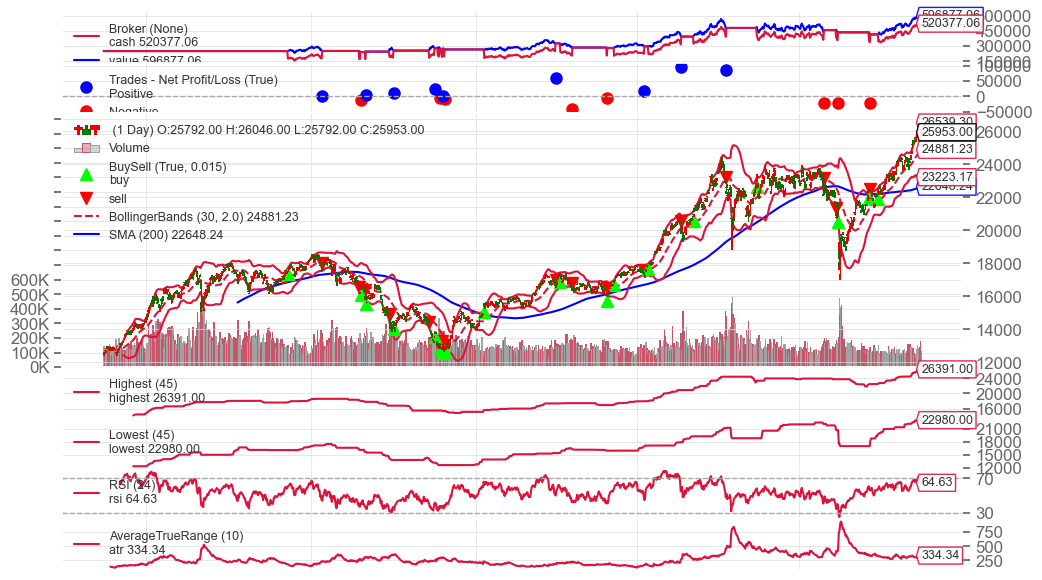

In [1]:
# =============================================================================
#
#  雙模式自適應整合策略 v16.0：簡化版（使用 bt_report_utils）
#
# =============================================================================
import backtrader as bt
import pandas as pd
import numpy as np
import sqlalchemy as sa
import urllib
from datetime import datetime, timedelta
import optuna
import quantstats as qs
import warnings

# 從自訂模組導入工具類別和函數
from bt_report_utils import (
    TaiFexCommInfo,           # 台指期貨手續費設定
    PnlListAnalyzer,          # 交易淨利分析器
    BaseLoggingStrategy,      # 包含日誌功能的基礎策略
    show_backtrader_report    # 完整報表生成函數
)

warnings.filterwarnings('ignore')

# =============================================================================
# 資料讀取與處理（與之前相同，保持不變）
# =============================================================================

def get_futures_data(start_date, end_date):
    """從資料庫讀取期貨資料"""
    try:
        server_name = "(localdb)\\MSSQLLocalDB"
        database_name = "quant"
        driver = "ODBC Driver 17 for SQL Server"
        params = urllib.parse.quote_plus(
            f"DRIVER={{{driver}}};SERVER={server_name};DATABASE={database_name};Trusted_Connection=yes;"
        )
        engine = sa.create_engine(f"mssql+pyodbc:///?odbc_connect={params}")
        
        sql_query = """
        SELECT [交易日期] AS [date], [開盤價] AS [open], [最高價] AS [high],
               [最低價] AS [low], [收盤價] AS [close], [成交量] AS [volume],
               [到期月份(週別)] AS [expiry]
        FROM dbo.期貨價格
        WHERE 契約 = 'MTX' AND [交易日期] BETWEEN ? AND ?
        ORDER BY [交易日期] ASC, [成交量] DESC;
        """
        df = pd.read_sql_query(sql_query, engine, params=(start_date, end_date))
    except Exception as e:
        print(f"讀取資料庫時發生錯誤: {e}")
        return None
    
    df['datetime'] = pd.to_datetime(df['date'])
    df.set_index('datetime', inplace=True)
    df.drop('date', axis=1, inplace=True)
    df.dropna(inplace=True)
    return df


def get_third_wednesday(year, month):
    """計算指定年月的第三個星期三（小指結算日）"""
    first_day = datetime(year, month, 1)
    days_ahead = 2 - first_day.weekday()
    if days_ahead < 0:
        days_ahead += 7
    first_wednesday = first_day + timedelta(days=days_ahead)
    third_wednesday = first_wednesday + timedelta(weeks=2)
    return third_wednesday.date()


def is_trading_day(date, trading_days_set):
    """檢查是否為交易日"""
    date_obj = date.date() if hasattr(date, 'date') else date
    return date_obj in trading_days_set


def get_next_trading_day(date, trading_days_list):
    """找到指定日期後的下一個交易日"""
    date_obj = date.date() if hasattr(date, 'date') else date
    for trading_day in trading_days_list:
        if trading_day > date_obj:
            return trading_day
    return None


def get_settlement_dates(start_date, end_date, raw_df):
    """獲取指定期間內所有的實際結算日期（考慮假日調整）"""
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    trading_days = sorted(list(set(raw_df.index.date)))
    trading_days_set = set(trading_days)
    settlement_dates = []
    
    current_date = start_dt
    while current_date <= end_dt:
        theoretical_settlement = get_third_wednesday(current_date.year, current_date.month)
        if start_dt.date() <= theoretical_settlement <= end_dt.date():
            if is_trading_day(theoretical_settlement, trading_days_set):
                actual_settlement = theoretical_settlement
            else:
                actual_settlement = get_next_trading_day(theoretical_settlement, trading_days)
                if not actual_settlement:
                    actual_settlement = theoretical_settlement
            settlement_dates.append(actual_settlement)
        current_date = current_date + pd.DateOffset(months=1)
    
    return sorted(settlement_dates)


def get_contract_month(date, settlement_dates):
    """根據日期和結算日判斷應該使用哪個月份的合約"""
    date_obj = date.date() if hasattr(date, 'date') else date
    for settlement_date in settlement_dates:
        if date_obj <= settlement_date:
            return f"{settlement_date.year}{settlement_date.month:02d}"
    
    if settlement_dates:
        last_settlement = settlement_dates[-1]
        if last_settlement.month == 12:
            return f"{last_settlement.year + 1}01"
        else:
            return f"{last_settlement.year}{last_settlement.month + 1:02d}"
    return None


def create_continuous_contract(raw_df):
    """基於結算日邏輯建立連續合約（不調整價格）"""
    print("正在使用結算日邏輯生成【非調整】連續合約...")
    raw_df['expiry'] = raw_df['expiry'].astype(str)
    date_range = [raw_df.index.min().date(), raw_df.index.max().date()]
    settlement_dates = get_settlement_dates(date_range[0], date_range[1], raw_df)
    
    continuous_data = []
    current_contract = None
    all_trading_days = sorted(list(set(raw_df.index)))
    
    for date in all_trading_days:
        date_data = raw_df[raw_df.index.date == date.date()]
        if date_data.empty:
            continue
        
        target_contract = get_contract_month(date.date(), settlement_dates)
        if target_contract is None:
            continue
        
        if target_contract != current_contract:
            current_contract = target_contract
        
        target_data = date_data[date_data['expiry'].str.contains(target_contract[:6], na=False)]
        if target_data.empty:
            target_data = date_data.loc[[date_data['volume'].idxmax()]]
        
        if len(target_data) > 1:
            target_data = target_data.loc[[target_data['volume'].idxmax()]]
        
        continuous_data.append({
            'date': date,
            'open': target_data['open'].iloc[0],
            'high': target_data['high'].iloc[0],
            'low': target_data['low'].iloc[0],
            'close': target_data['close'].iloc[0],
            'volume': target_data['volume'].iloc[0]
        })
    
    continuous_df = pd.DataFrame(continuous_data)
    continuous_df.set_index('date', inplace=True)
    continuous_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    continuous_df.dropna(inplace=True)
    
    # 確保 high/low 的合理性
    continuous_df['high'] = continuous_df[['open', 'high', 'low', 'close']].max(axis=1)
    continuous_df['low'] = continuous_df[['open', 'high', 'low', 'close']].min(axis=1)
    
    result_df = continuous_df[['open', 'high', 'low', 'close', 'volume']]
    print(f"\n連續合約建立完成, 日期範圍: {result_df.index.min().date()} 到 {result_df.index.max().date()}")
    return result_df

# =============================================================================
# 雙模式自適應策略定義（繼承 BaseLoggingStrategy）
# =============================================================================

class AdaptiveIntegratedStrategy(BaseLoggingStrategy):
    """
    雙模式自適應整合策略：
    - 牛市模式：積極做多 + ATR 追蹤止損
    - 熊市/震盪模式：保守放空 + 多指標過濾
    
    繼承 BaseLoggingStrategy 以自動獲得交易日誌功能
    """
    params = dict(
        # 基礎指標參數
        lookback_period=20,      # 唐奇安通道週期
        rsi_period=14,           # RSI 週期
        bollinger_period=20,     # 布林通道週期
        std_dev=2.0,             # 布林通道標準差倍數
        
        # 市場模式判斷參數
        long_ma_period=200,      # 長期均線週期（用於判斷牛熊市）
        
        # ATR 止損參數
        atr_period=14,           # ATR 計算週期
        atr_multiplier=3.0,      # ATR 倍數（止損距離）
        
        printlog=False           # 是否顯示日誌
    )
    
    def __init__(self):
        # 呼叫父類初始化（獲得 self.order 等屬性和日誌功能）
        super().__init__()
        
        # 基礎技術指標
        self.donchian_high = bt.indicators.Highest(
            self.data.high, 
            period=self.p.lookback_period
        )
        self.donchian_low = bt.indicators.Lowest(
            self.data.low, 
            period=self.p.lookback_period
        )
        self.rsi = bt.indicators.RSI(period=self.p.rsi_period)
        self.bband = bt.indicators.BollingerBands(
            period=self.p.bollinger_period, 
            devfactor=self.p.std_dev
        )
        
        # 市場模式判斷指標
        self.long_ma = bt.indicators.SMA(
            self.data.close, 
            period=self.p.long_ma_period
        )
        
        # ATR 指標（用於動態止損）
        self.atr = bt.indicators.AverageTrueRange(period=self.p.atr_period)
        
        # 追蹤止損價格（僅用於牛市模式的多單）
        self.trailing_stop_price = 0
    
    def notify_trade(self, trade):
        """
        交易狀態通知（覆寫父類方法以添加 ATR 止損初始化）
        """
        # 先呼叫父類的 notify_trade（記錄交易損益）
        super().notify_trade(trade)
        
        # 當交易開啟時，如果是牛市模式下的多單，初始化 ATR 止損
        if trade.isopen:
            is_bull_market = self.data.close[0] > self.long_ma[0]
            if is_bull_market and trade.size > 0:
                self.trailing_stop_price = trade.price - self.p.atr_multiplier * self.atr[0]
                if self.p.printlog:
                    self.log(f'初始化 ATR 止損 @ {self.trailing_stop_price:.2f}')
    
    def next(self):
        # 確保所有指標都有足夠數據
        if len(self.data) < self.p.long_ma_period:
            return
        
        # ===== 步驟一：判斷市場模式 =====
        is_bull_market = self.data.close[0] > self.long_ma[0]
        
        # ===== 步驟二：根據模式執行對應的交易邏輯 =====
        
        if self.position:
            # ----- 出場邏輯 -----
            
            if is_bull_market and self.position.size > 0:
                # 牛市模式多單出場：使用 ATR 追蹤止損
                new_stop_price = self.data.close[0] - self.p.atr_multiplier * self.atr[0]
                
                # 追蹤止損只會上移，不會下移
                if new_stop_price > self.trailing_stop_price:
                    self.trailing_stop_price = new_stop_price
                    if self.p.printlog:
                        self.log(f'更新 ATR 止損 @ {self.trailing_stop_price:.2f}')
                
                # 價格跌破止損線，平倉
                if self.data.close[0] <= self.trailing_stop_price:
                    if self.p.printlog:
                        self.log(f'觸發 ATR 止損，平倉 @ {self.data.close[0]:.2f}')
                    self.close()
            
            else:
                # 非牛市模式出場：使用保守的唐奇安通道出場
                if self.position.size > 0:
                    # 多單：唐奇安高點不再創新高時出場
                    if self.donchian_high[0] <= self.donchian_high[-1]:
                        if self.p.printlog:
                            self.log('唐奇安高點未創新高，平多單')
                        self.close()
                
                elif self.position.size < 0:
                    # 空單：唐奇安低點不再創新低時出場
                    if self.donchian_low[0] >= self.donchian_low[-1]:
                        if self.p.printlog:
                            self.log('唐奇安低點未創新低，平空單')
                        self.close()
        
        elif not self.position:
            # ----- 進場邏輯 -----
            
            if is_bull_market:
                # 牛市模式進場：積極做多（唐奇安突破即進場）
                if self.donchian_high[0] > self.donchian_high[-1]:
                    if self.p.printlog:
                        self.log(f'牛市模式：唐奇安突破，做多 @ {self.data.close[0]:.2f}')
                    self.buy()
            
            else:
                # 非牛市模式進場：保守放空（需多重過濾條件）
                is_donchian_falling = self.donchian_low[0] < self.donchian_low[-1]
                is_rsi_not_oversold = self.rsi[0] > 30
                is_not_bb_extreme_short = self.data.close[0] > self.bband.lines.bot[0]
                
                if is_donchian_falling and is_rsi_not_oversold and is_not_bb_extreme_short:
                    if self.p.printlog:
                        self.log(f'熊市模式：多重條件滿足，放空 @ {self.data.close[0]:.2f}')
                    self.sell()

# =============================================================================
# 輔助函數：添加標準分析器
# =============================================================================

def add_standard_analyzers(cerebro):
    """
    為 Cerebro 添加標準分析器組合
    這些分析器是 show_backtrader_report() 所需要的
    """
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe_ratio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')
    cerebro.addanalyzer(PnlListAnalyzer, _name='pnllistanalyzer')
    return cerebro

# =============================================================================
# Optuna 優化目標函數
# =============================================================================

def objective(trial, data, initial_cash, slippage_ticks, tick_size):
    """Optuna 優化目標函數：最大化 Sharpe Ratio"""
    params = {
        'lookback_period': trial.suggest_int('lookback_period', 20, 60, step=5),
        'rsi_period': trial.suggest_int('rsi_period', 10, 30, step=2),
        'bollinger_period': trial.suggest_int('bollinger_period', 15, 30, step=5),
        'std_dev': trial.suggest_float('std_dev', 1.5, 3.0, step=0.25),
        'long_ma_period': trial.suggest_categorical('long_ma_period', [150, 200, 250]),
        'atr_period': trial.suggest_int('atr_period', 10, 20),
        'atr_multiplier': trial.suggest_float('atr_multiplier', 2.0, 4.0, step=0.5)
    }
    
    try:
        cerebro = bt.Cerebro(stdstats=False)
        cerebro.adddata(bt.feeds.PandasData(dataname=data))
        cerebro.addstrategy(AdaptiveIntegratedStrategy, **params)
        
        # 設定初始資金和手續費
        cerebro.broker.setcash(initial_cash)
        cerebro.broker.addcommissioninfo(TaiFexCommInfo())
        cerebro.broker.set_slippage_fixed(slippage_ticks * tick_size)
        
        # 只添加 Sharpe Ratio 分析器用於優化
        cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe_ratio')
        
        results = cerebro.run()
        sharpe = results[0].analyzers.sharpe_ratio.get_analysis().get('sharperatio', -2.0)
        return sharpe if sharpe is not None else -2.0
    
    except Exception:
        return -999.0

# =============================================================================
# 主執行程式
# =============================================================================

if __name__ == '__main__':
    # 回測參數設定
    START_DATE = '2020-09-30'#因為ROLLING五年驗證半年的結果最好，所以用五年然後每年刷一次參數
    END_DATE = '2025-09-30'
    INITIAL_CASH = 250000
    SLIPPAGE_TICKS = 5
    TICK_SIZE = 1
    OPTUNA_TRIALS = 100
    
    # 1. 讀取資料
    print("=" * 70)
    print("步驟 1: 讀取期貨資料")
    print("=" * 70)
    raw_dataframe = get_futures_data(start_date=START_DATE, end_date=END_DATE)
    
    if raw_dataframe is None or raw_dataframe.empty:
        print("❌ 無法讀取資料，程式結束")
        exit(1)
    
    # 2. 建立連續合約
    print("\n" + "=" * 70)
    print("步驟 2: 建立連續合約")
    print("=" * 70)
    dataframe = create_continuous_contract(raw_dataframe)
    
    # 3. Optuna 參數優化
    print("\n" + "=" * 70)
    print(f"步驟 3: 開始參數優化 (共 {OPTUNA_TRIALS} 次試驗)")
    print("=" * 70)
    print("策略特色：雙模式自適應（牛市積極做多 + 熊市保守放空）")
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42)  # 設定隨機種子確保可重現性
    )
    study.optimize(
        lambda trial: objective(trial, dataframe, INITIAL_CASH, SLIPPAGE_TICKS, TICK_SIZE),
        n_trials=OPTUNA_TRIALS,
        show_progress_bar=True
    )
    
    best_trial = study.best_trial
    print("\n--- Optuna 優化完成 ---")
    print(f"最佳 Sharpe Ratio: {best_trial.value:.4f}")
    print(f"最佳參數組合:")
    for key, value in best_trial.params.items():
        print(f"  {key}: {value}")
    
    # 4. 使用最佳參數執行最終回測
    print("\n" + "=" * 70)
    print("步驟 4: 執行最終回測")
    print("=" * 70)
    cerebro_final = bt.Cerebro()
    cerebro_final.adddata(bt.feeds.PandasData(dataname=dataframe))
    cerebro_final.addstrategy(
        AdaptiveIntegratedStrategy, 
        printlog=True,  # 顯示詳細交易日誌
        **best_trial.params
    )
    
    # 設定初始資金和手續費
    cerebro_final.broker.setcash(INITIAL_CASH)
    cerebro_final.broker.addcommissioninfo(TaiFexCommInfo())
    cerebro_final.broker.set_slippage_fixed(SLIPPAGE_TICKS * TICK_SIZE)
    
    # 添加標準分析器組合
    add_standard_analyzers(cerebro_final)
    
    # 執行回測
    final_run_results = cerebro_final.run()
    
    # 5. 顯示完整報表（使用 bt_report_utils）
    print("\n" + "=" * 70)
    print("步驟 5: 績效報表")
    print("=" * 70)
    show_backtrader_report(
        final_run_results, 
        cerebro_final, 
        dataframe, 
        strategy_name="AdaptiveIntegratedStrategy"
    )
    
    # 6. 生成 QuantStats 報告
    print("\n" + "=" * 70)
    print("步驟 6: 生成 QuantStats 報告")
    print("=" * 70)
    returns = pd.Series(final_run_results[0].analyzers.timereturn.get_analysis())
    benchmark = dataframe['close'].pct_change().reindex(returns.index).fillna(0)
    
    qs.reports.html(
        returns,
        benchmark=benchmark,
        output='adaptive_integrated_strategy_report.html',
        title='Adaptive Integrated Strategy v16.0'
    )
    print("✅ QuantStats 報告已生成: adaptive_integrated_strategy_report.html")
    
    # 7. 顯示 BackTrader 圖表
    print("\n" + "=" * 70)
    print("步驟 7: 顯示交易圖表")
    print("=" * 70)
    cerebro_final.plot(style='candlestick', barup='red', bardown='green')
    
    print("\n" + "=" * 70)
    print("🎉 所有步驟完成！")
    print("=" * 70)
    print("\n策略說明：")
    print("  • 牛市模式（價格 > 200MA）：積極做多 + ATR 追蹤止損")
    print("  • 熊市模式（價格 < 200MA）：保守放空 + 多指標過濾")
    print("  • 自動根據市場狀態切換交易邏輯")

rolling

In [ ]:
# =============================================================================
# 主執行程式 (滾動優化版本: 6個月訓練 / 3個月測試)
# =============================================================================

# =============================================================================
# 主執行程式 (滾動優化版本: 12個月訓練 / 6個月測試)
# =============================================================================

if __name__ == '__main__':
    # ===== 滾動優化參數設定 =====
    TRAIN_MONTHS = 60        # 【修改】每次優化（訓練）要用幾個月的數據
    TEST_MONTHS = 6          # 【修改】每次樣本外（測試）要跑幾個月的數據
    
    # ===== 指標預熱期設定 =====
    # 根據 Optuna 參數 long_ma_period 的最大值 250 來設定，再加一點緩衝
    WARMUP_PERIOD_DAYS = 260 
    
    # ===== 全局回測參數設定 =====
    START_DATE = '2015-09-30'
    END_DATE = '2025-09-30'
    INITIAL_CASH = 250000
    SLIPPAGE_TICKS = 5
    TICK_SIZE = 1
    OPTUNA_TRIALS = 50

    # 1. 讀取全部資料
    print("=" * 70)
    print(f"步驟 1: 讀取 {START_DATE} 到 {END_DATE} 的全部期貨資料")
    print("=" * 70)
    raw_dataframe = get_futures_data(start_date=START_DATE, end_date=END_DATE)
    if raw_dataframe is None or raw_dataframe.empty:
        print("❌ 無法讀取資料，程式結束")
        exit(1)

    # 2. 建立完整的連續合約
    print("\n" + "=" * 70)
    print("步驟 2: 建立完整週期的連續合約")
    print("=" * 70)
    dataframe = create_continuous_contract(raw_dataframe)
    
    # ===== 滾動優化主循環 =====
    print("\n" + "=" * 70)
    print(f"步驟 3: 開始滾動優化 (訓練週期: {TRAIN_MONTHS}個月, 測試週期: {TEST_MONTHS}個月)")
    print("=" * 70)
    
    all_oos_returns = []
    
    start_date = pd.to_datetime(dataframe.index.min().date())
    end_date = pd.to_datetime(dataframe.index.max().date())
    
    loop_count = 1
    
    while True:
        # 定義訓練集和測試集的時間範圍
        train_start_date = start_date
        train_end_date = train_start_date + pd.DateOffset(months=TRAIN_MONTHS)
        test_start_date = train_end_date + pd.Timedelta(days=1)
        test_end_date = test_start_date + pd.DateOffset(months=TEST_MONTHS)
        
        if test_end_date > end_date:
            break
            
        print(f"\n--- 滾動週期 #{loop_count} ---")
        print(f"  訓練期 (In-Sample)  : {train_start_date.date()} -> {train_end_date.date()}")
        print(f"  測試期 (Out-of-Sample): {test_start_date.date()} -> {test_end_date.date()}")
        
        # 切割訓練數據
        train_data = dataframe.loc[train_start_date:train_end_date]
        
        # 確保訓練數據足夠長，能容納指標預熱期
        if len(train_data) < WARMUP_PERIOD_DAYS:
            print(f"  ⚠️ 訓練期數據不足 ({len(train_data)} < {WARMUP_PERIOD_DAYS})，跳過此週期。")
            start_date = start_date + pd.DateOffset(months=TEST_MONTHS)
            loop_count += 1
            continue

        # ## --- 訓練階段 (In-Sample Optimization) --- ##
        print("  正在進行參數優化...")
        # 【關鍵修正】建立一個帶有固定種子的採樣器
        sampler = optuna.samplers.TPESampler(seed=42) 
        # 在建立 study 時傳入這個採樣器
        study = optuna.create_study(direction='maximize', sampler=sampler)
        study.optimize(
            lambda trial: objective(trial, train_data, INITIAL_CASH, SLIPPAGE_TICKS, TICK_SIZE),
            n_trials=OPTUNA_TRIALS,
            show_progress_bar=False
        )
        best_params = study.best_trial.params
        print(f"  當期最佳參數: {best_params}")

        # ## --- 測試階段 (Out-of-Sample Backtest) --- ##
        print("  正在執行樣本外測試...")
        
        warmup_start_date = test_start_date - pd.DateOffset(days=WARMUP_PERIOD_DAYS)
        test_data_with_warmup = dataframe.loc[warmup_start_date:test_end_date]
        
        cerebro_oos = bt.Cerebro()
        cerebro_oos.adddata(bt.feeds.PandasData(dataname=test_data_with_warmup))
        cerebro_oos.addstrategy(AdaptiveIntegratedStrategy, **best_params)
        cerebro_oos.broker.setcash(INITIAL_CASH)
        cerebro_oos.broker.addcommissioninfo(TaiFexCommInfo())
        cerebro_oos.broker.set_slippage_fixed(SLIPPAGE_TICKS * TICK_SIZE)
        cerebro_oos.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')
        
        results_oos = cerebro_oos.run(fromdate=test_start_date, todate=test_end_date)
        
        # ## --- 收集結果並滾動窗口 --- ##
        oos_returns = pd.Series(results_oos[0].analyzers.timereturn.get_analysis())
        all_oos_returns.append(oos_returns)
        print(f"  本週期測試完成，共 {len(oos_returns)} 個交易日。")
        
        # 準備下一次循環：將起始日期向前滾動 測試期 的長度
        start_date = start_date + pd.DateOffset(months=TEST_MONTHS)
        loop_count += 1

    # 4. 合併所有樣本外績效並生成最終報告
    print("\n" + "=" * 70)
    print("步驟 4: 整合所有樣本外績效並生成最終報告")
    print("=" * 70)
    
    if not all_oos_returns:
        print("❌ 沒有足夠的數據來完成任何一個滾動優化週期。")
        exit(1)
        
    final_returns = pd.concat(all_oos_returns)
    final_returns = final_returns[~final_returns.index.duplicated(keep='first')]
    final_returns.index = pd.to_datetime(final_returns.index)
    final_returns = final_returns.sort_index()
    
    benchmark = dataframe['close'].pct_change().reindex(final_returns.index).fillna(0)
    
    qs.reports.html(
        final_returns,
        benchmark=benchmark,
        output='walk_forward_strategy_report.html',
        title=f'Adaptive Walk-Forward Analysis (Train:{TRAIN_MONTHS}m, Test:{TEST_MONTHS}m)'
    )
    print("✅ QuantStats 滾動優化報告已生成: walk_forward_strategy_report.html")

    # 手動計算並印出幾個關鍵的總體指標
    print("\n--- 滾動優化最終績效總覽 ---")
    total_return = (1 + final_returns).prod() - 1
    num_years = (final_returns.index.max() - final_returns.index.min()).days / 365.25
    annual_return = ((1 + total_return) ** (1/num_years) - 1) if num_years > 0 and total_return > -1 else 0
    annual_volatility = final_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility if annual_volatility > 0 else 0
    
    equity_curve = (1 + final_returns).cumprod()
    peak = equity_curve.cummax()
    drawdown = (equity_curve - peak) / peak
    max_drawdown = drawdown.min()
    
    print(f"總回測期間: {final_returns.index.min().date()} -> {final_returns.index.max().date()}")
    print(f"總報酬率: {total_return:.2%}")
    print(f"年化報酬率: {annual_return:.2%}")
    print(f"年化波動率: {annual_volatility:.2%}")
    print(f"夏普比率: {sharpe_ratio:.2f}")
    print(f"最大回撤: {max_drawdown:.2%}")

    print("\n" + "=" * 70)
    print("🎉 滾動優化分析完成！")
    print("=" * 70)

步驟 1: 讀取 2015-09-30 到 2025-09-30 的全部期貨資料

步驟 2: 建立完整週期的連續合約
正在使用結算日邏輯生成【非調整】連續合約...

連續合約建立完成, 日期範圍: 2015-09-30 到 2025-09-30

步驟 3: 開始滾動優化 (訓練週期: 60個月, 測試週期: 6個月)

--- 滾動週期 #1 ---
  訓練期 (In-Sample)  : 2015-09-30 -> 2020-09-30
  測試期 (Out-of-Sample): 2020-10-01 -> 2021-04-01
  正在進行參數優化...
2016-05-16 賣出執行 @ 8021.00, 成本: 76500.00, 手續費: 30.02
2016-05-17 買進執行 @ 8082.00, 成本: 76500.00, 手續費: 30.08
2016-05-17 交易損益: 毛利 -3050.00, 淨利 -3110.10
2016-06-13 買進執行 @ 8639.00, 成本: 76500.00, 手續費: 30.64
2016-06-17 賣出執行 @ 8343.00, 成本: 76500.00, 手續費: 30.34
2016-06-17 交易損益: 毛利 -14800.00, 淨利 -14860.98
2016-07-12 買進執行 @ 8755.00, 成本: 76500.00, 手續費: 30.76
2016-09-19 賣出執行 @ 8935.00, 成本: 76500.00, 手續費: 30.94
2016-09-19 交易損益: 毛利 9000.00, 淨利 8938.31
2016-09-30 買進執行 @ 9192.00, 成本: 76500.00, 手續費: 31.19
2016-11-10 賣出執行 @ 9134.00, 成本: 76500.00, 手續費: 31.13
2016-11-10 交易損益: 毛利 -2900.00, 淨利 -2962.33
2016-12-12 買進執行 @ 9425.00, 成本: 76500.00, 手續費: 31.43
2016-12-26 賣出執行 @ 9100.00, 成本: 76500.00, 手續費: 31.10
2016-12-26 交易損益: 毛利 -162

[W 2025-11-12 13:31:07,182] Trial 44 failed with parameters: {'lookback_period': 40, 'rsi_period': 28, 'bollinger_period': 15, 'std_dev': 2.25, 'long_ma_period': 250, 'atr_period': 11, 'atr_multiplier': 3.0} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\DELL\miniforge3\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\3164036365.py", line 84, in <lambda>
    lambda trial: objective(trial, train_data, INITIAL_CASH, SLIPPAGE_TICKS, TICK_SIZE),
                  ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\268018743.py", line 365, in objective
    results = cerebro.run()
  File "c:\Users\DELL\miniforge3\Lib\site-packages\backtrader\cerebro.py", line 1132, in run
    runstrat = self.runstrategies(iterstrat)
  File "c:\Users\DELL\miniforge3\Li

KeyboardInterrupt: 